In [1]:
%load_ext snakeviz
%autoreload 2
import importlib

In [2]:
import sys
sys.path.append('/Users/dsuess/Code/Pythonlibs')

import mpnum as mp
from mptomo.tiht import tiht_np, tiht_mpa
import mptomo.tiht as tiht
import numpy as np
import h5py

from numpy import float_
from tools.helpers import Progress, Timer, TimelyProgress, RuntimeSlice, CountSlice
from itertools import islice

In [10]:
RGEN = np.random.RandomState(seed=0)
SITES = 6
RANK = 4
LDIM = 5
MEAS = 6 * SITES * RANK**2 * LDIM
BATCHSIZE = 150
RETINFO = ['mu']

X = mp.random_mpa(SITES, LDIM, RANK, randstate=RGEN,
                  normalized=True, dtype=float_)
X /= mp.norm(X)

A = [mp.random_mpa(SITES, LDIM, 1, randstate=RGEN, normalized=False, dtype=np.float_) / MEAS
     for _ in range(MEAS)] 

y = np.array([mp.inner(a, X) for a in A])


In [11]:
stepfun = tiht.memory_stepsize(tiht.locally_projected(tiht.adaptive_stepsize()),
                               const_steps=50)
solution = tiht_mpa(A, y, 2 * RANK, batchsize=BATCHSIZE, stepsize=stepfun, retinfo=['mu'])
result = list(a for a in Progress(RuntimeSlice(solution, 60), rettime=True))

TypeError: 'MPArray' object is not subscriptable

In [ ]:
stepfun = tiht.memory_stepsize(tiht.fully_projected(tiht.adaptive_stepsize()), 
                               const_steps=50)
solution = tiht_mpa(A, y, 2 * RANK, batchsize=50, stepsize=stepfun, retinfo=['mu', 'X_for_stepsize'])
result2 = list(a for a in Progress(RuntimeSlice(solution, 60), rettime=True))

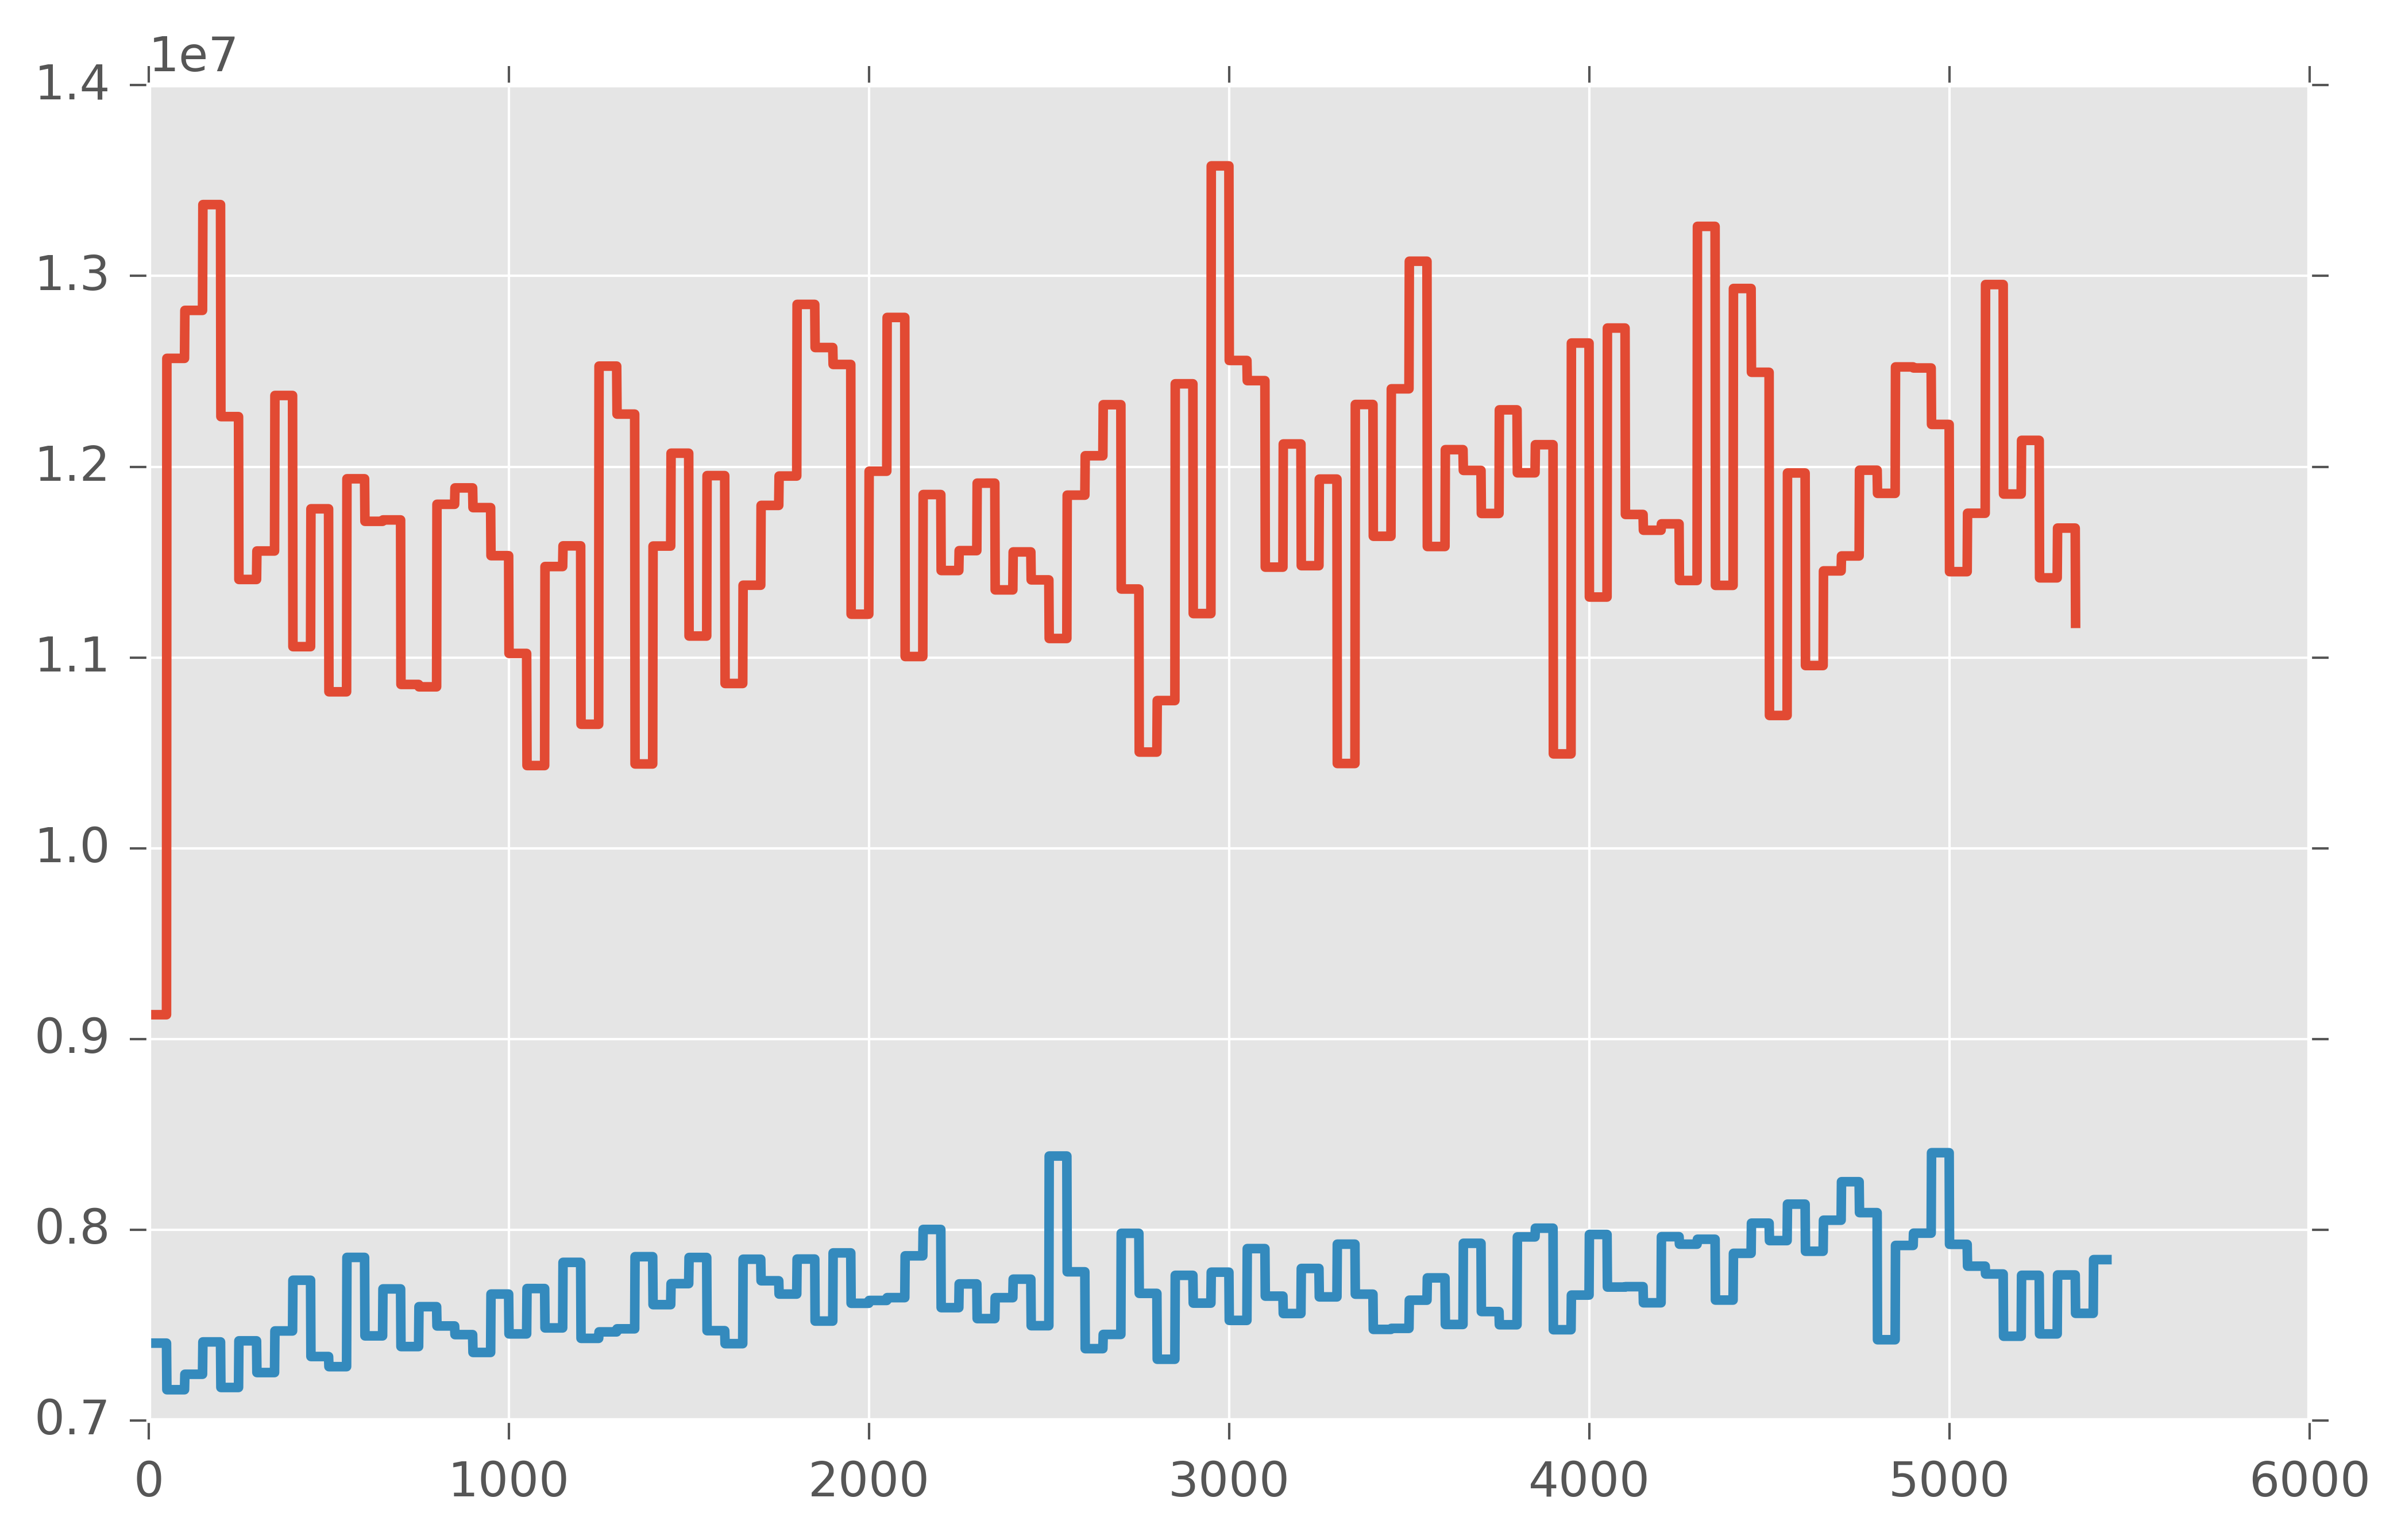

In [113]:
pl.plot([info['mu'] for _, (_, info) in result])
pl.plot([info['mu'] for _, (_, info) in result2])

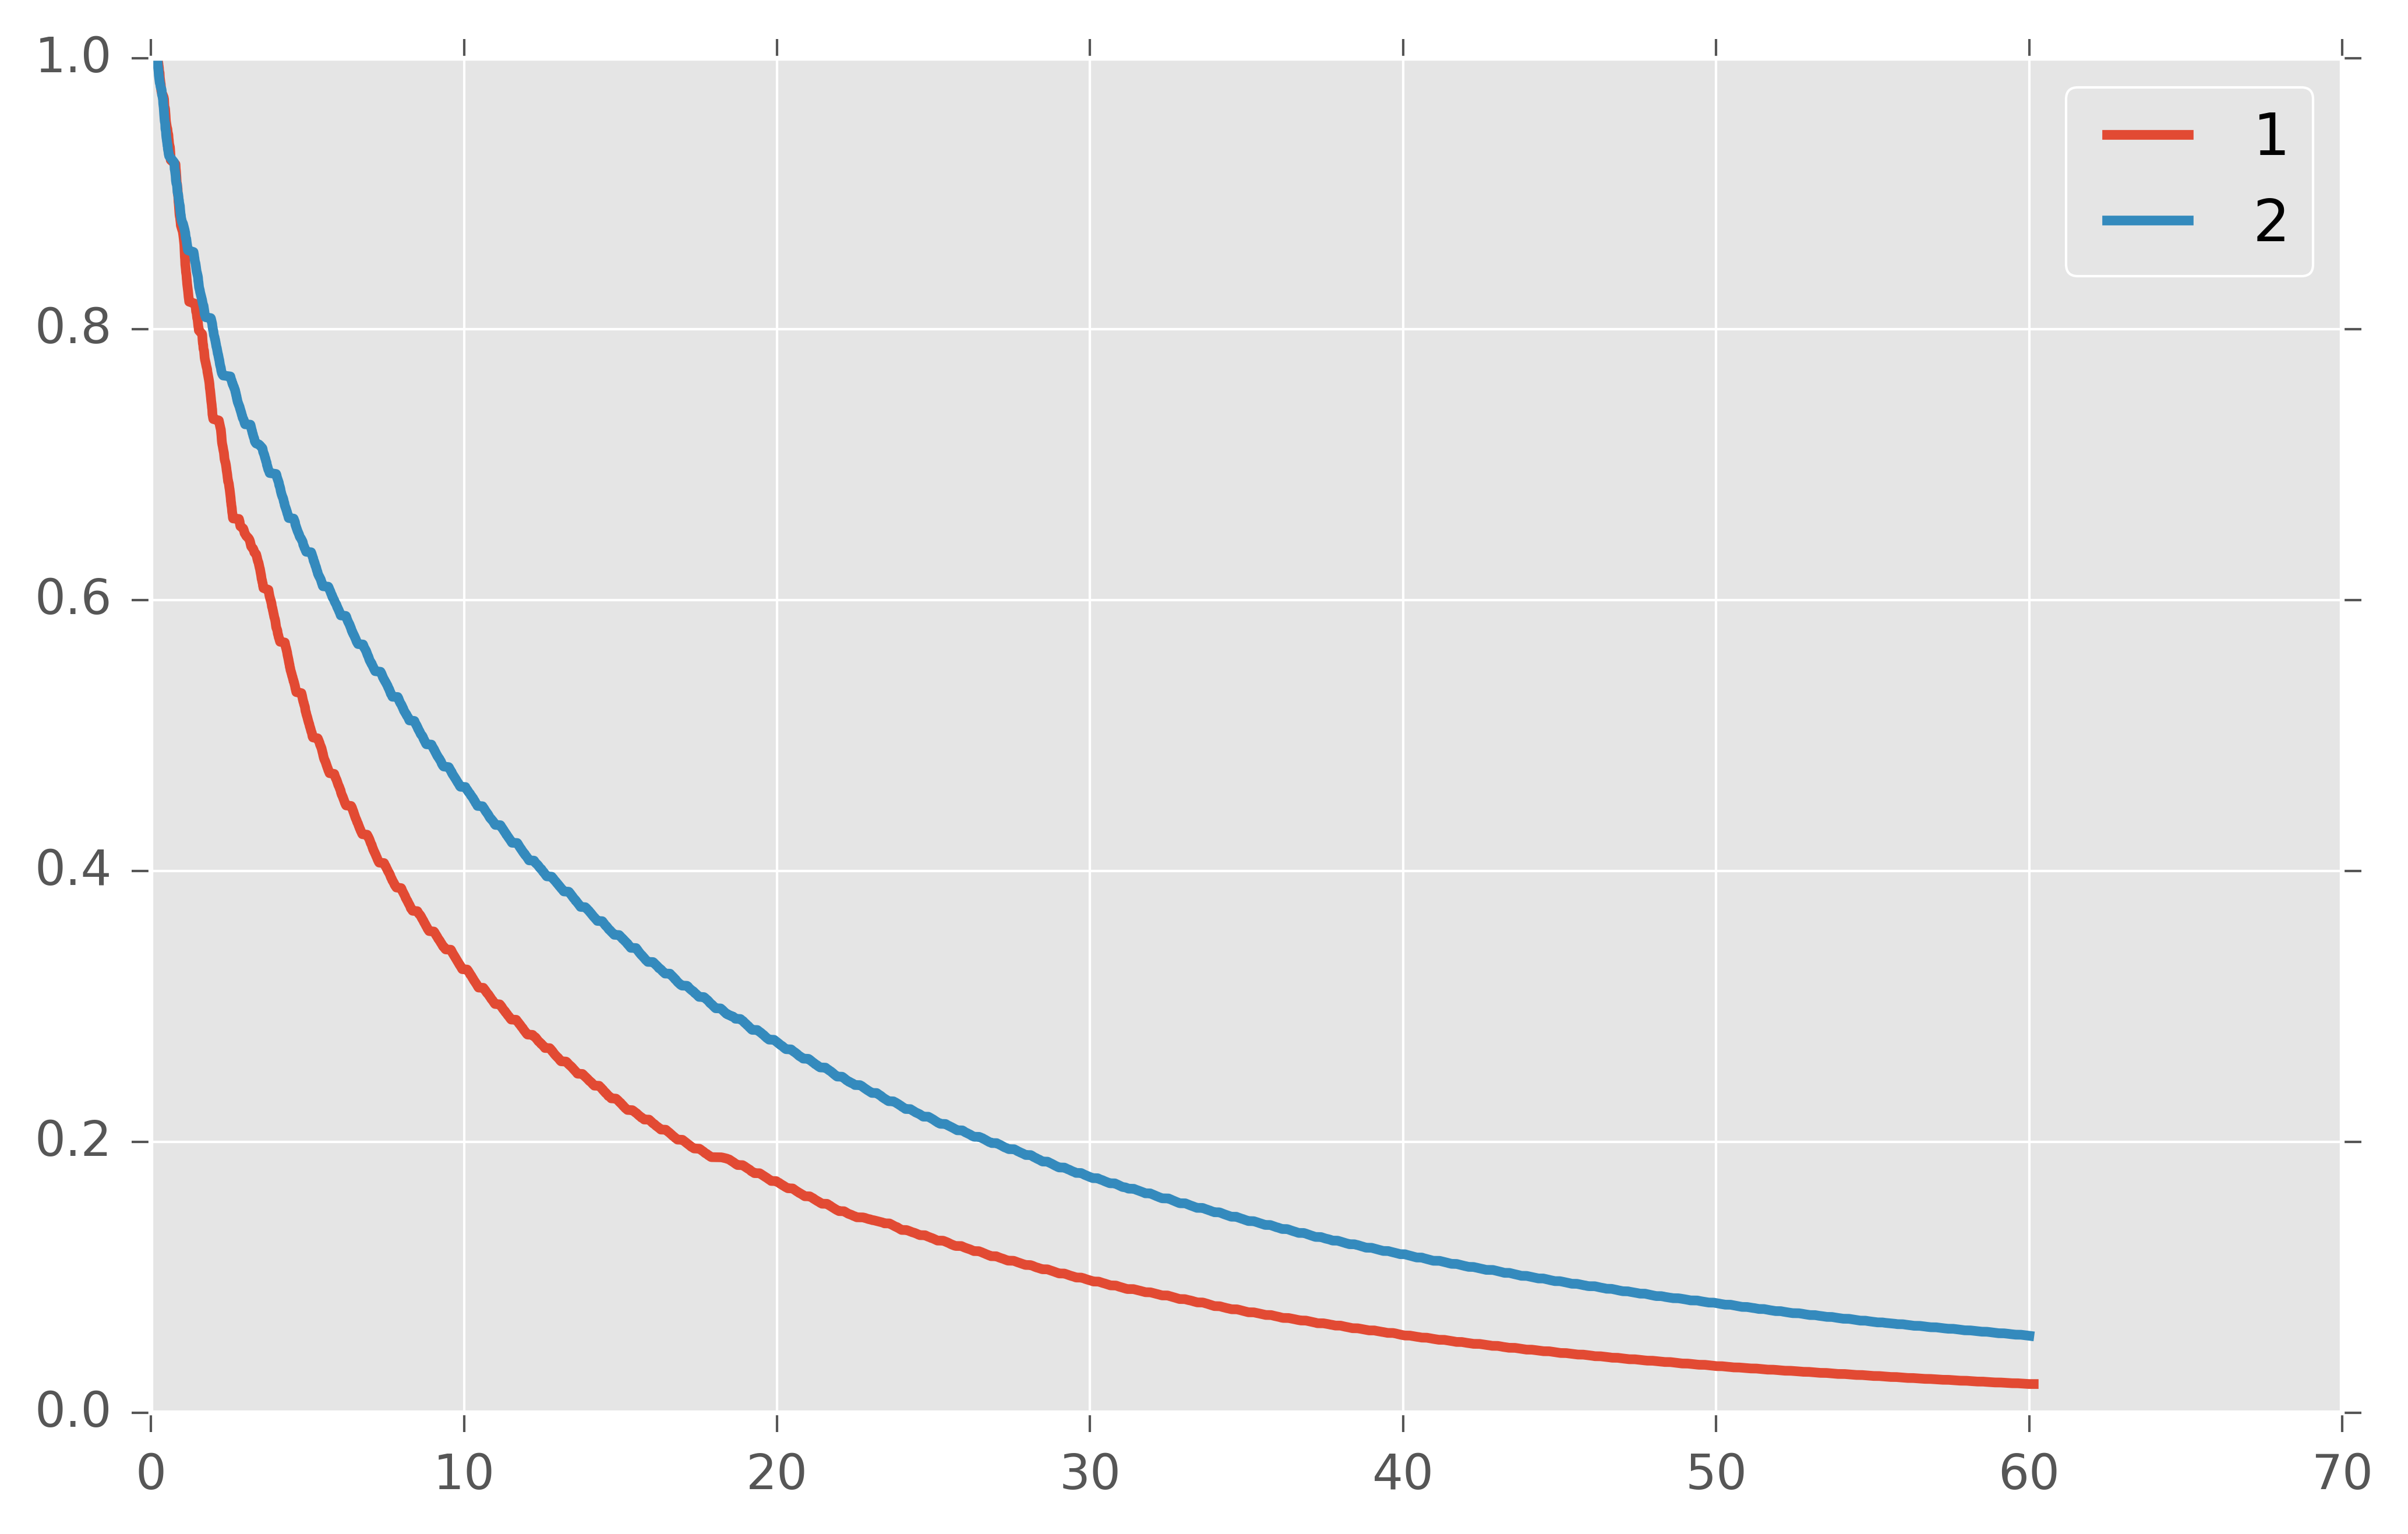

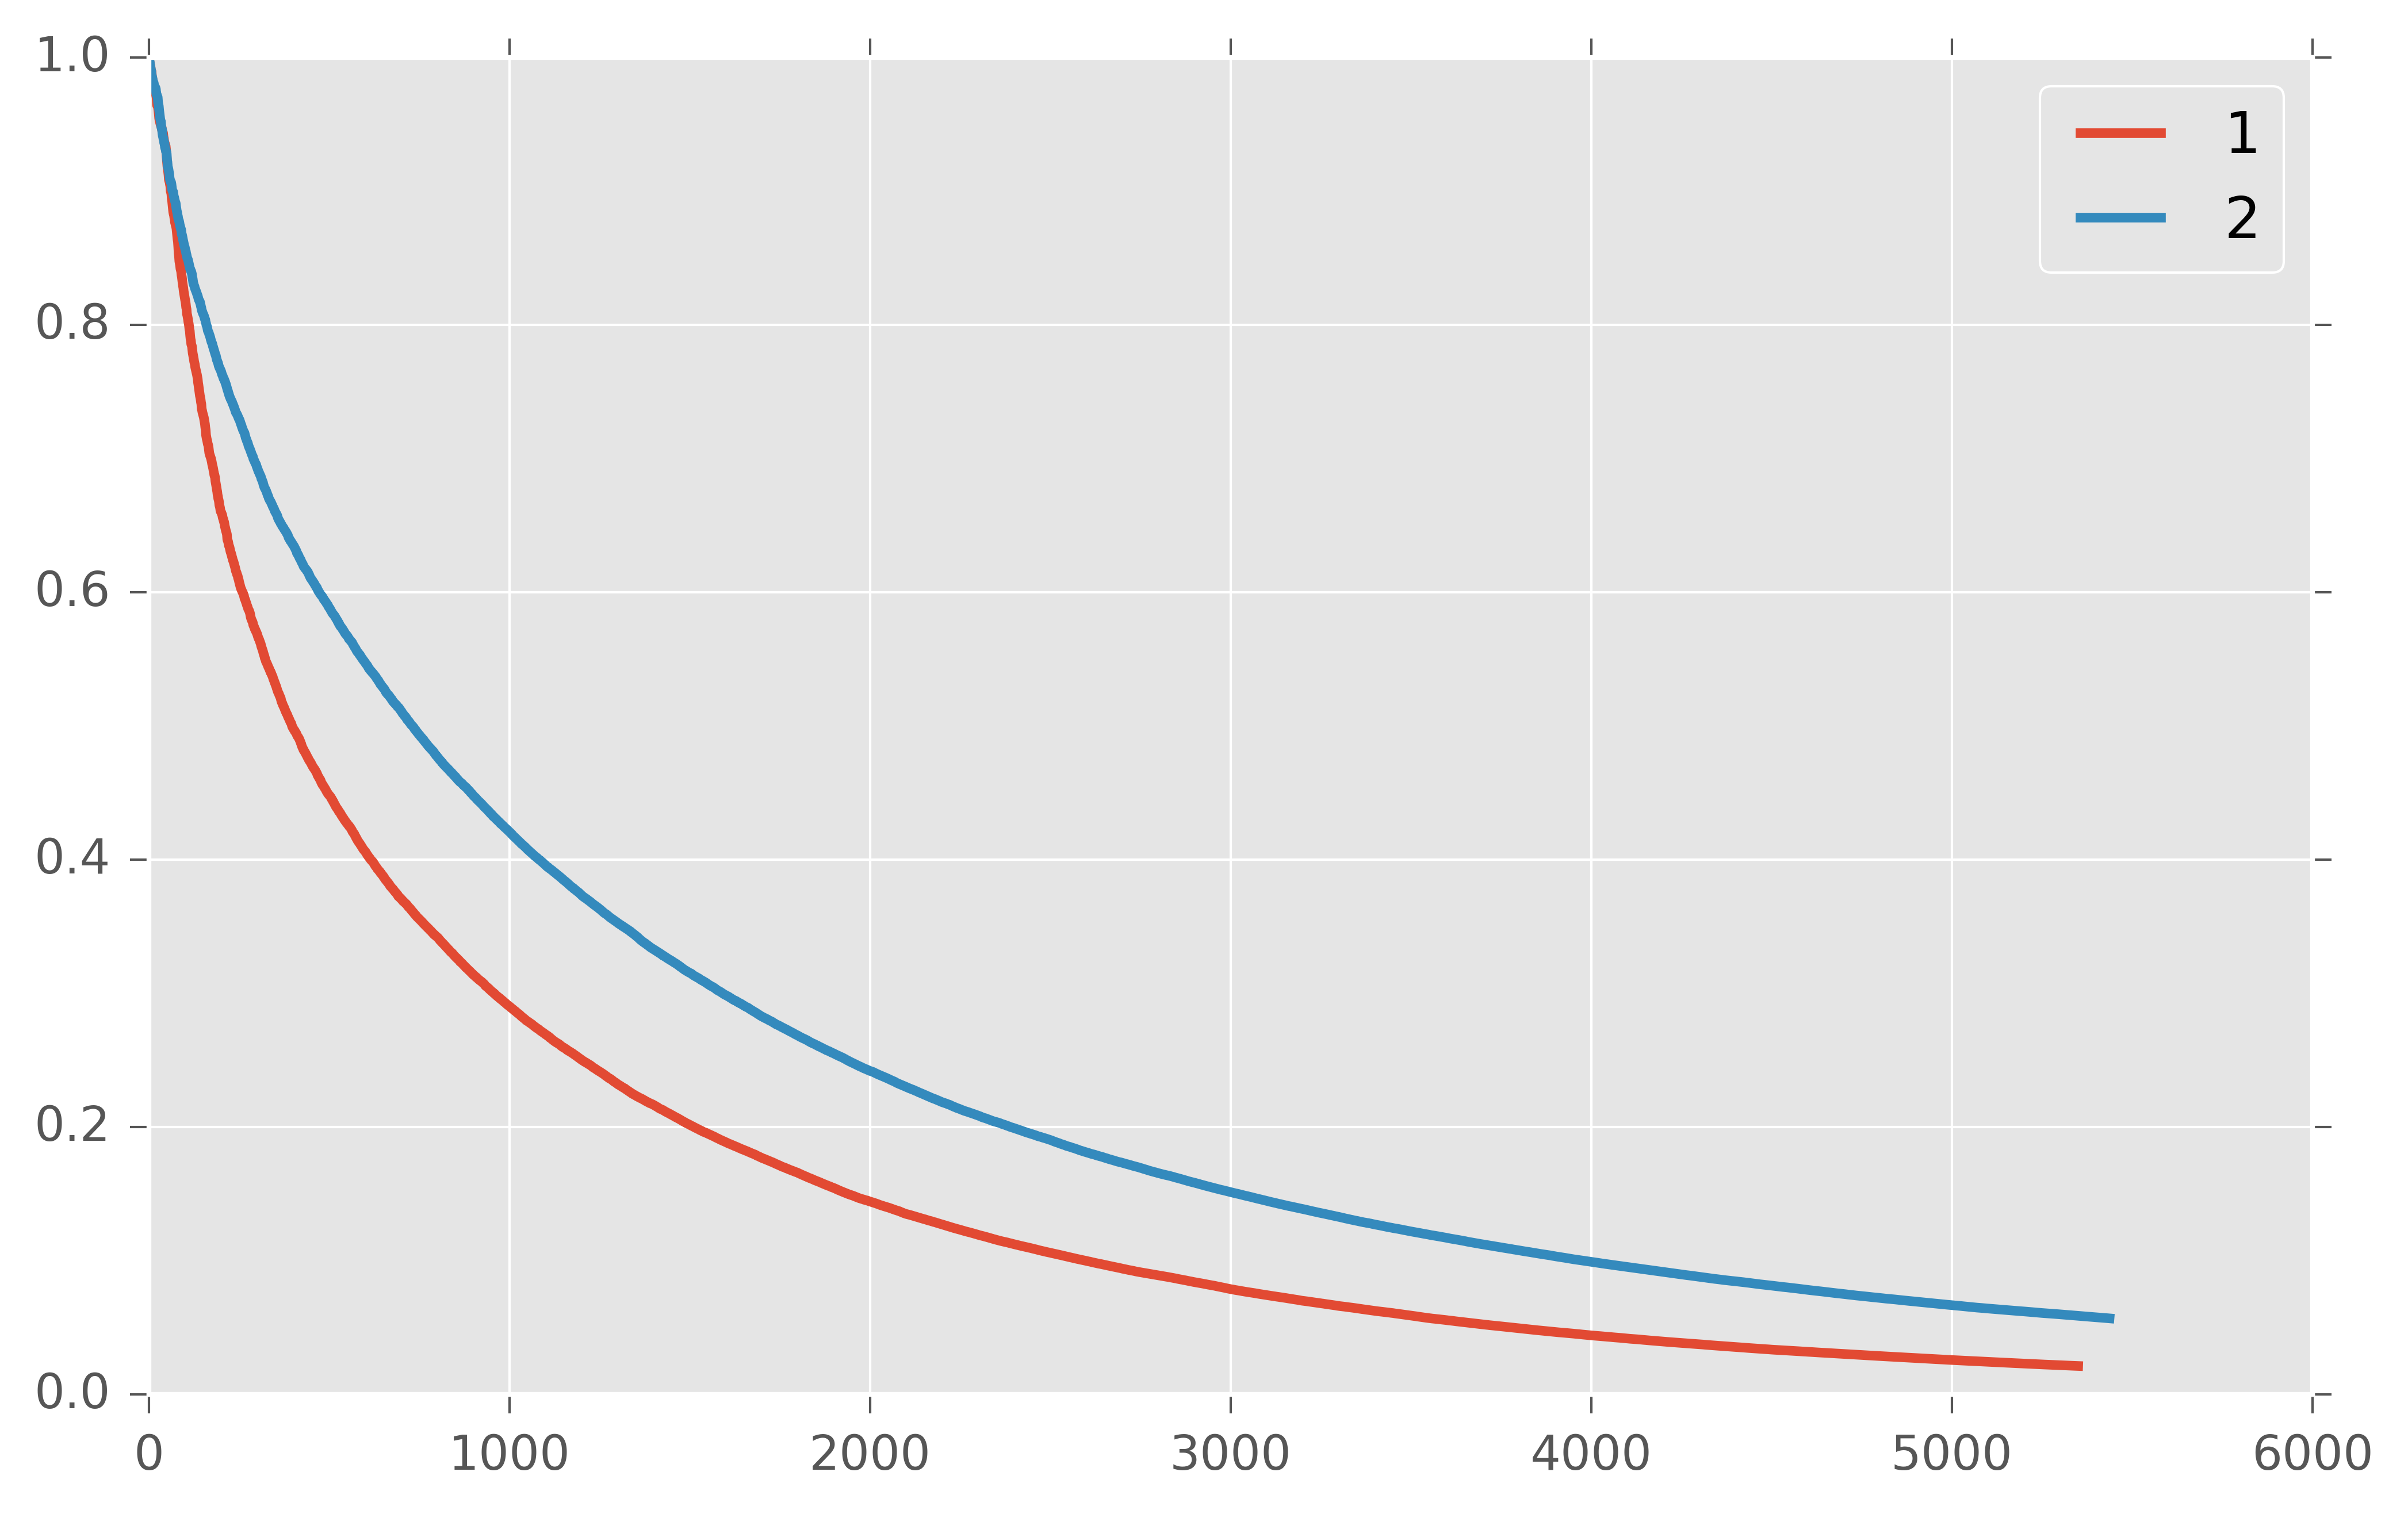

In [114]:
pl.plot([t for t, _ in result], [mp.normdist(X, Xsharp) for _, (Xsharp, _) in result], label='1')
pl.plot([t for t, _ in result2], [mp.normdist(X, Xsharp) for _, (Xsharp, _) in result2], label='2')

pl.legend()
pl.show()

pl.plot([mp.normdist(X, Xsharp) for _, (Xsharp, _) in result], label='1')
pl.plot([mp.normdist(X, Xsharp) for _, (Xsharp, _) in result2], label='2')

pl.legend()
pl.show()

In [64]:
Xs = [info['X_for_stepsize'] for _, (_, info) in result2]

In [66]:
X = Xs[5]
X.normalize(left=len(X) - 1)

# get the left-eigenvectors
Us, _ = X.split(len(X) - 2)
Us = Us.reshape([s + (1,) for s in Us.pdims[:-1]] + [Us.pdims[-1]])
proj = mp.dot(Us.conj(), Us, axes=(1, 1))


In [74]:
a = np.array([1, 2, 3])

In [82]:
def local_proj(l):
    l = np.rollaxis(l, 1).reshape((l.shape[1], -1))
    return np.tensordot(l.conj(), l, axes=(1, 1))

In [95]:
def locally_projected(stepfun, compargs={}):
    def stepsize(A, g, X):
        proj = mp.MPArray([local_proj(l)[None, ..., None] for l in X[:-1]])
        g = mp.partialdot(proj, g, start_at=0)
        g.compress(**compargs)

        return stepfun(A, g, _)
    return stepsize

In [90]:
[local_proj(l)[None, ... , None].shape for l in X[:-1]]

[(1, 10, 10, 1), (1, 10, 10, 1)]

In [91]:
proj = mp.MPArray([local_proj(l)[None, ..., None] for l in X[:-1]])

In [92]:
mp.normdist(mp.dot(proj, proj), proj)

6.0975218522976471

In [48]:
def overlap(mpa1, mpa2):
    return mp.inner(mpa1, mpa2) / mp.norm(mpa1.copy()) / mp.norm(mpa2.copy())

def get_overlaps(result, *args, **kwargs):
    for _, (_, info) in result:
        g = mp.sumup(info['A_'], weights=(info['y_'] - info['y_sharp']))
        compr, _ = g.compression(*args, **kwargs)
        yield overlap(g, compr), compr.bdim

 98% (61 of 62) |######################## | Elapsed Time: 0:00:25 ETA:  0:00:00

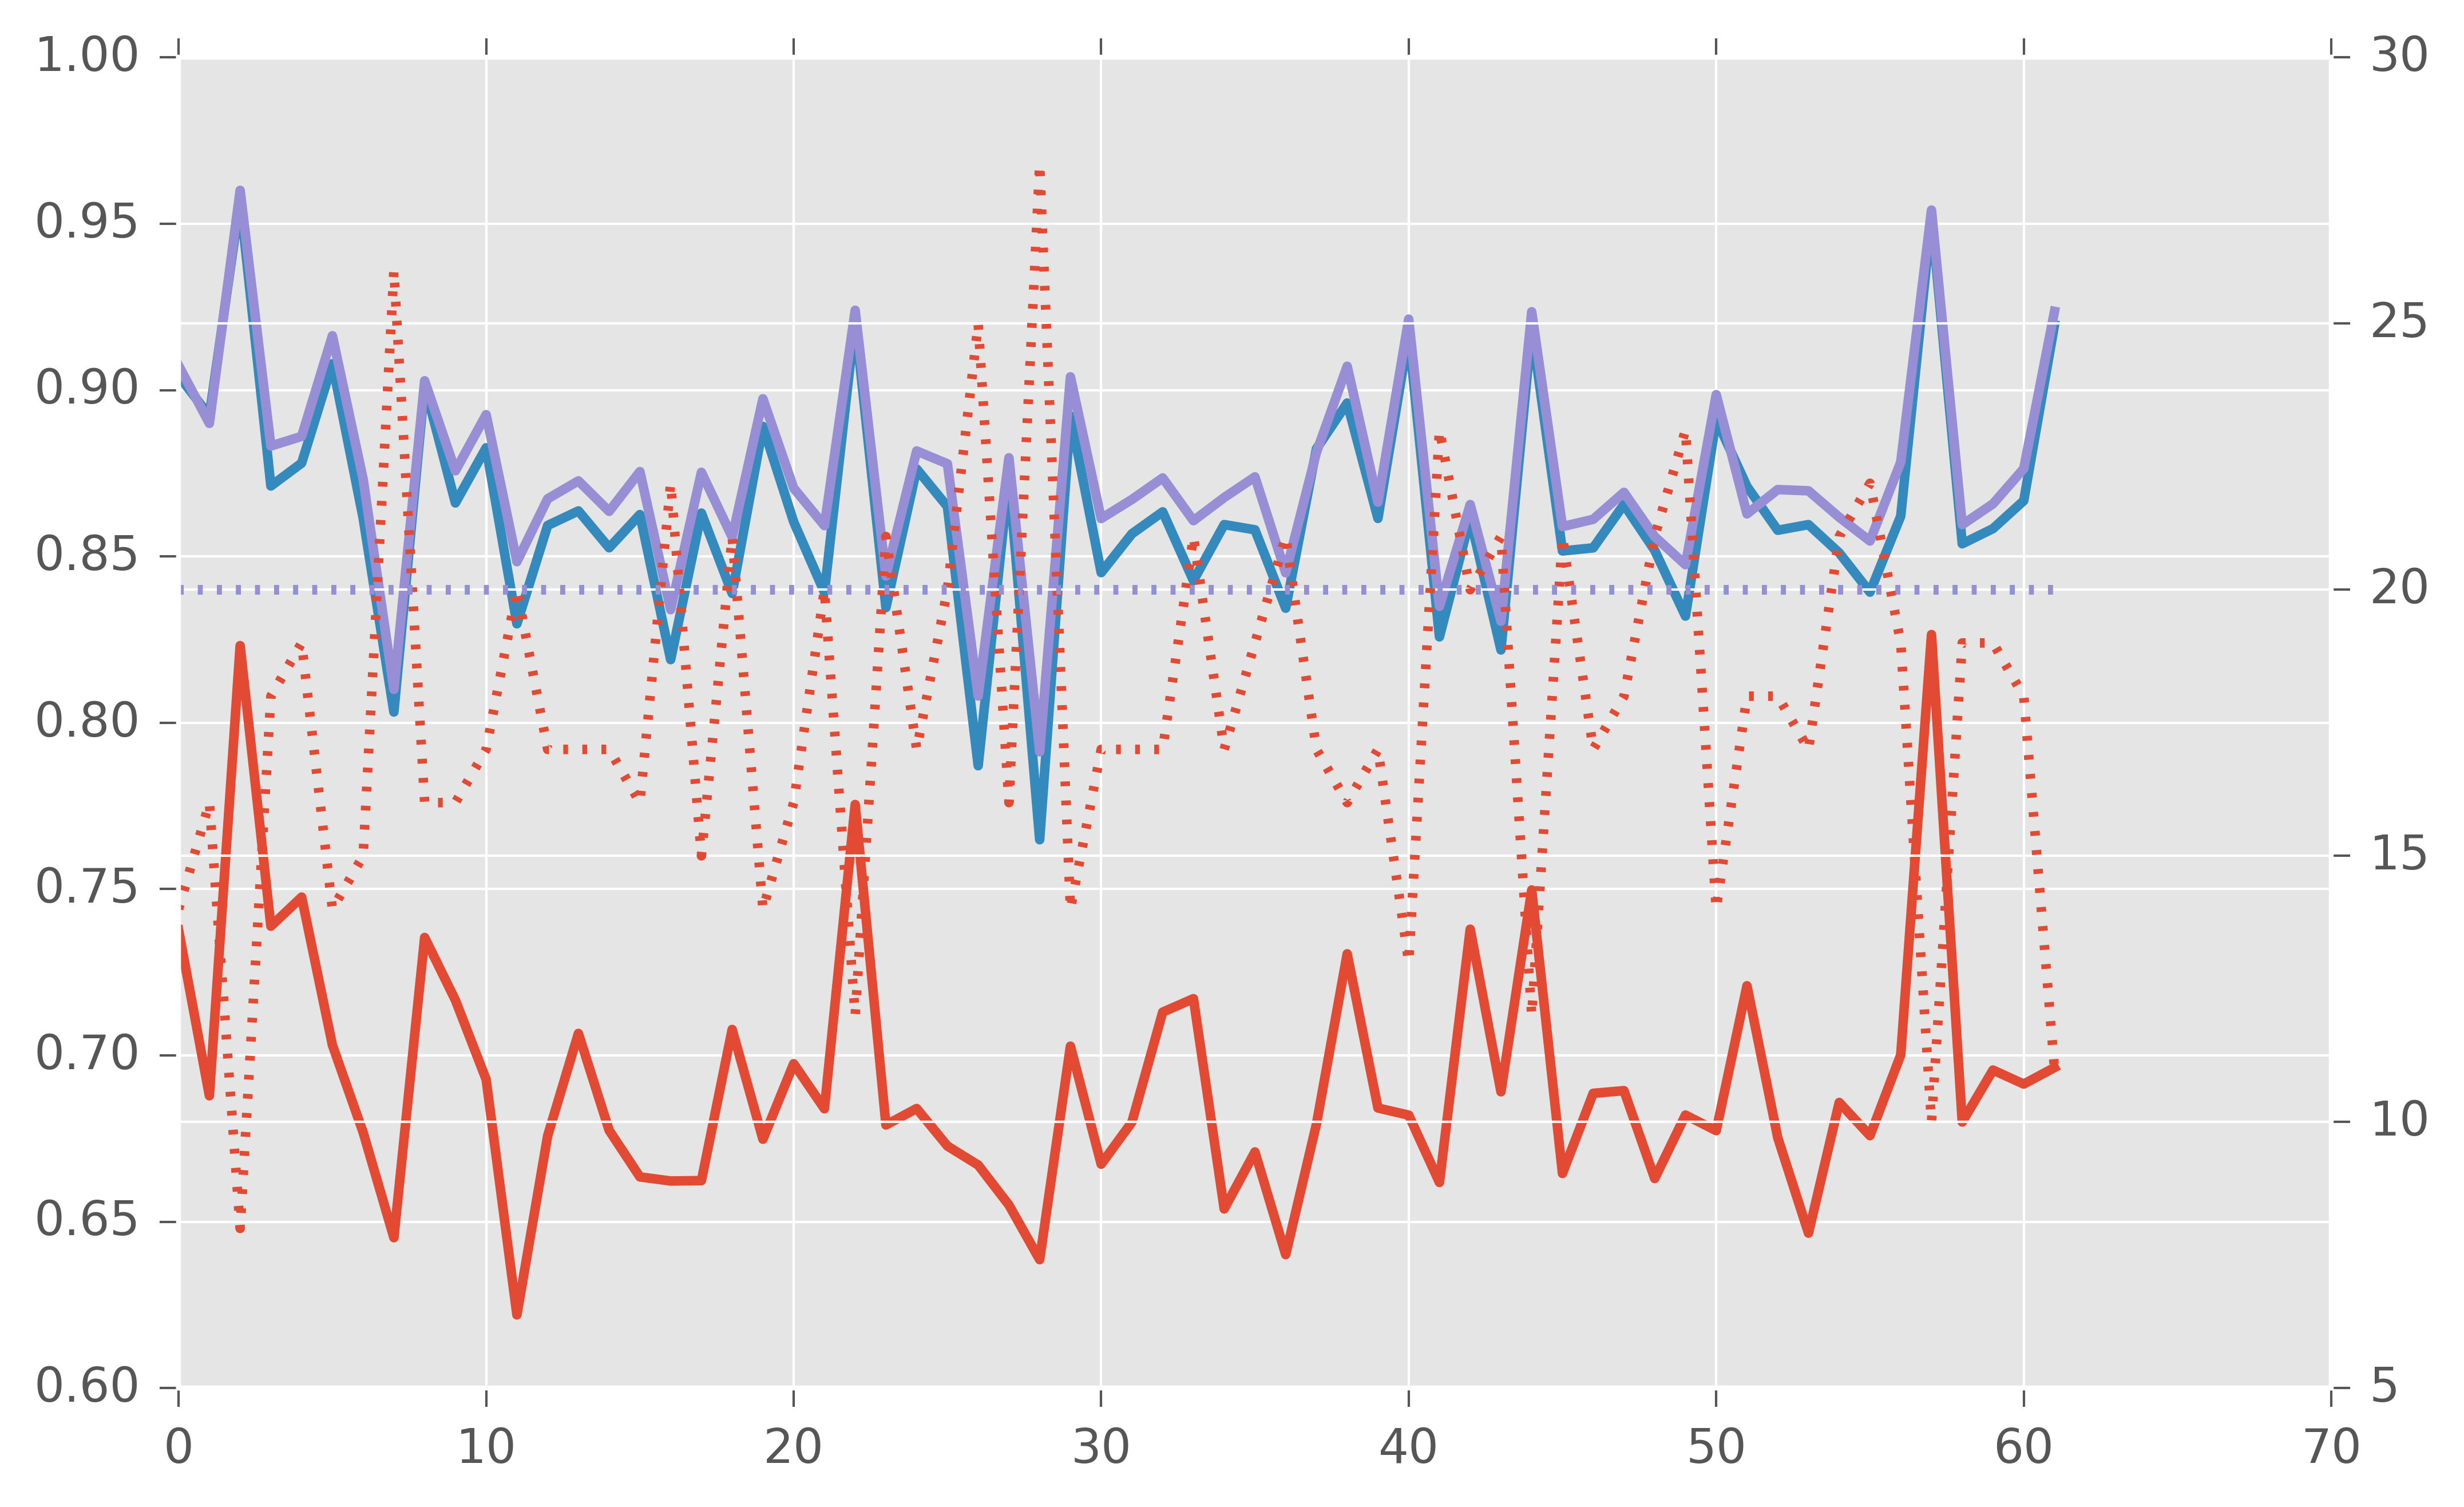

In [49]:
axl = pl.gca()
axr = axl.twinx()

with_relerr = list(get_overlaps(Progress(result), 'svd', relerr=0.3))
axl.plot([ol for ol, _ in with_relerr])
axr.plot([bdim for _, bdim in with_relerr], ls=":")

with_relerr = list(get_overlaps(Progress(result), 'svd', bdim=4 * RANK))
axl.plot([ol for ol, _ in with_relerr])
axr.plot([bdim for _, bdim in with_relerr], ls=":") 

with_relerr = list(get_overlaps(Progress(result), 'var', bdim=4 * RANK))
axl.plot([ol for ol, _ in with_relerr])
axr.plot([bdim for _, bdim in with_relerr], ls=":") 

### Checking for batchsize

In [29]:
np.random.shuffle?

In [30]:
result = dict()

for batchsize in reversed([50, 100, 150, 200, 300, 400, 500, 600, 1000]):
    solution = tiht_mpa(A, y, 2 * RANK, batchsize=batchsize,
                       stepsize={'method': 'adaptive_noproj', 'recalc': 50, 'join': 'average', 'scale': 1.3})
    result[batchsize] = list(a for a in Progress(RuntimeSlice(solution, 30), rettime=True))

100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30


In [24]:
with h5py.File('batchsize_scan_8.h5', 'w') as buf:
    for varname in ['SITES', 'RANK', 'LDIM', 'MEAS']:
        buf.attrs[varname] = globals()[varname]
    
    X.dump(buf.create_group('X'))
    X.dump(buf.create_group('A'))
    
    for key, val in result.items():
        group = buf.create_group(str(key))
        for time, X_sharp in val:
            X_sharp.dump(group.create_group(str(time)))

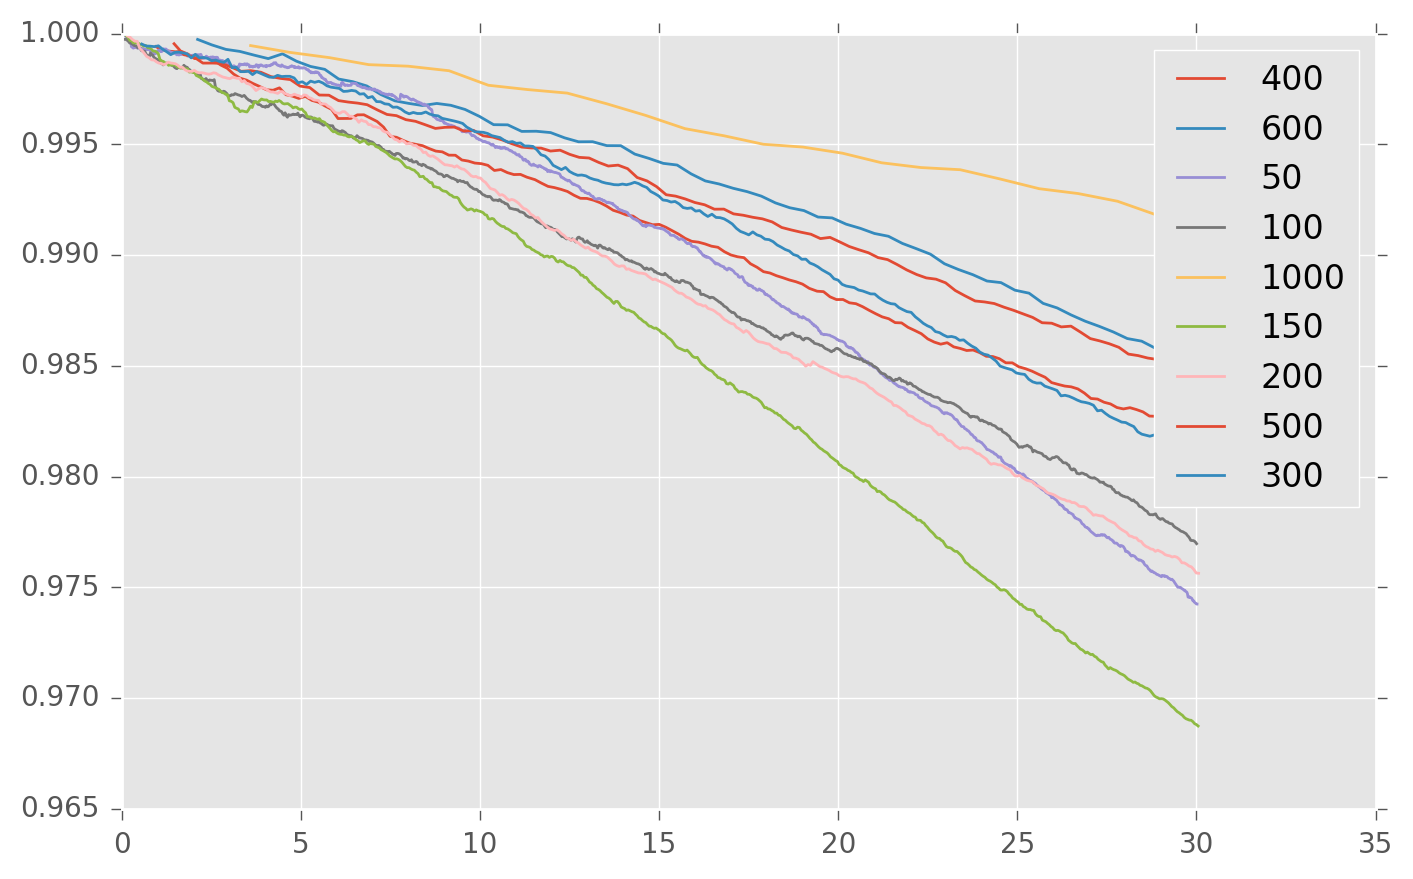

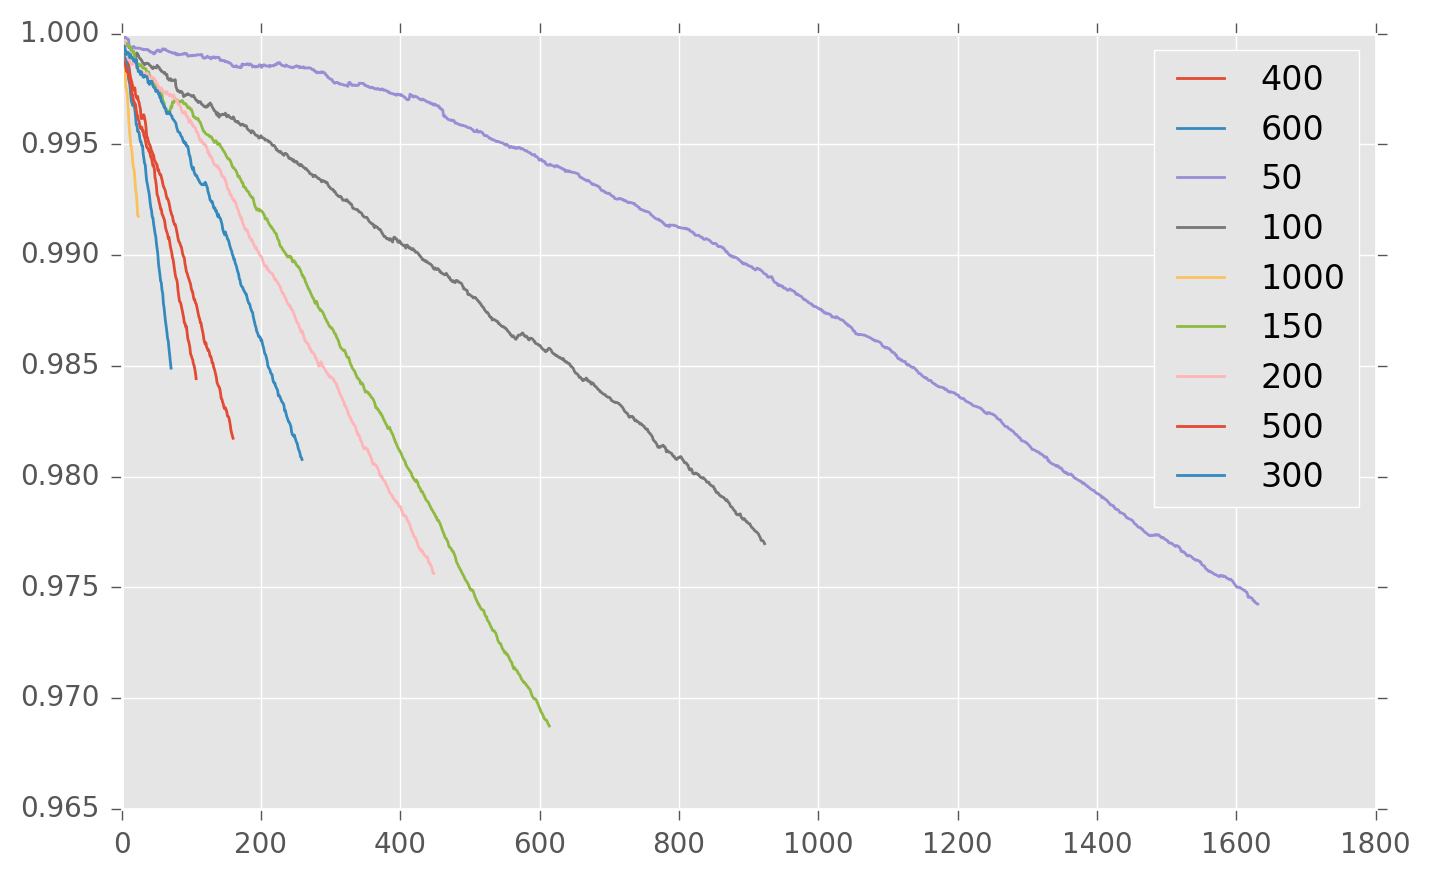

In [25]:
for key, val in result.items():
    pl.plot([t for t, _ in val], [mp.normdist(X, Xsharp) for _, Xsharp in val], label=key)

pl.legend()
pl.show()

for key, val in result.items():
    pl.plot([mp.normdist(X, Xsharp) for _, Xsharp in val], label=key)

pl.legend()
pl.show()

In [26]:
del result

### Checking stepsize

100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30


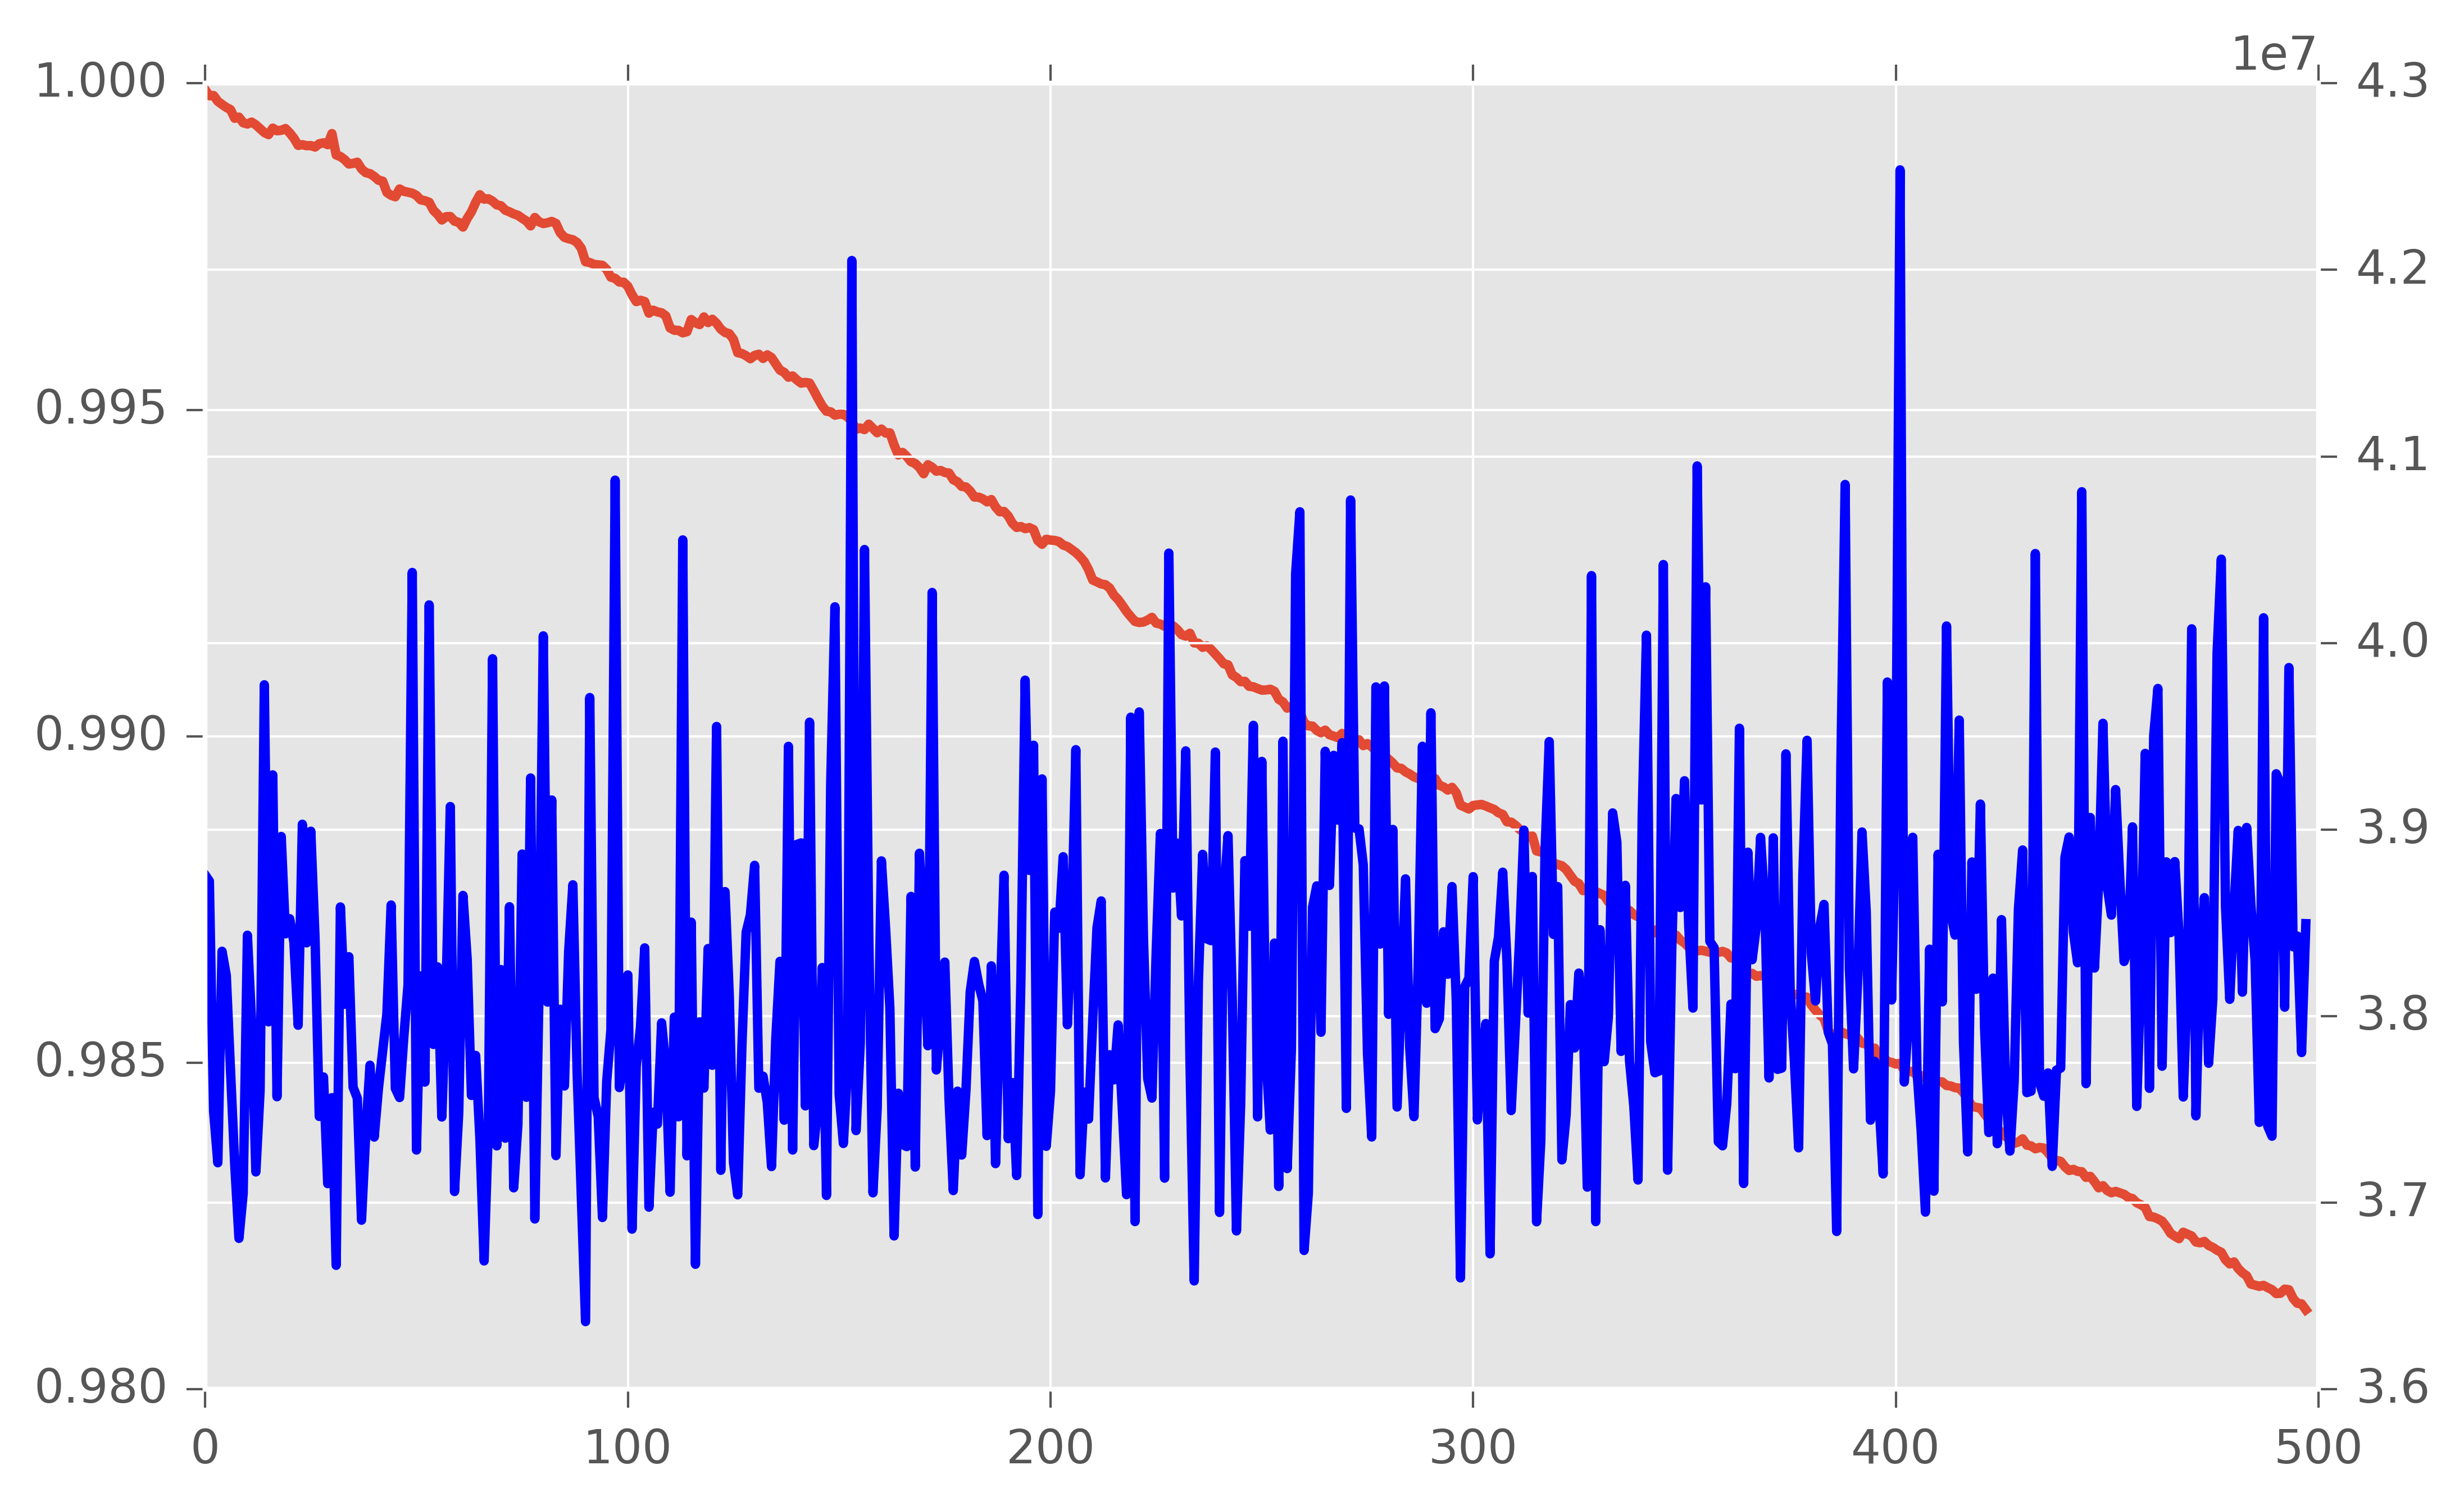

In [12]:
solution = tiht_mpa(A, y, 2 * RANK, batchsize=150, 
                    retinfo=['mu'])
result = list(a for a in Progress(RuntimeSlice(solution, 30), rettime=True))
pl.plot([mp.normdist(X, X_sharp) for _, (X_sharp, _) in result])
pl.gca().twinx().plot([info['mu'] for _, (_, info) in result], color='b')

In [20]:
%%snakeviz

solution = tiht_mpa(A, y, 2 * RANK, batchsize=150, retinfo=['mu'],
                    stepsize={'method': 'adaptive_noproj', 'recalc': 50, 'join': 'average', 'scale': 1.3})
result_r = list(a for a in Progress(RuntimeSlice(solution, 30), rettime=True))

100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30


 
*** Profile stats marshalled to file '/var/folders/25/5c0947xn1md22_9d8vgnm45w0000gn/T/tmpwwvjqsng'. 


100% |#######################################| Elapsed Time: 0:00:30 / 00:00:30


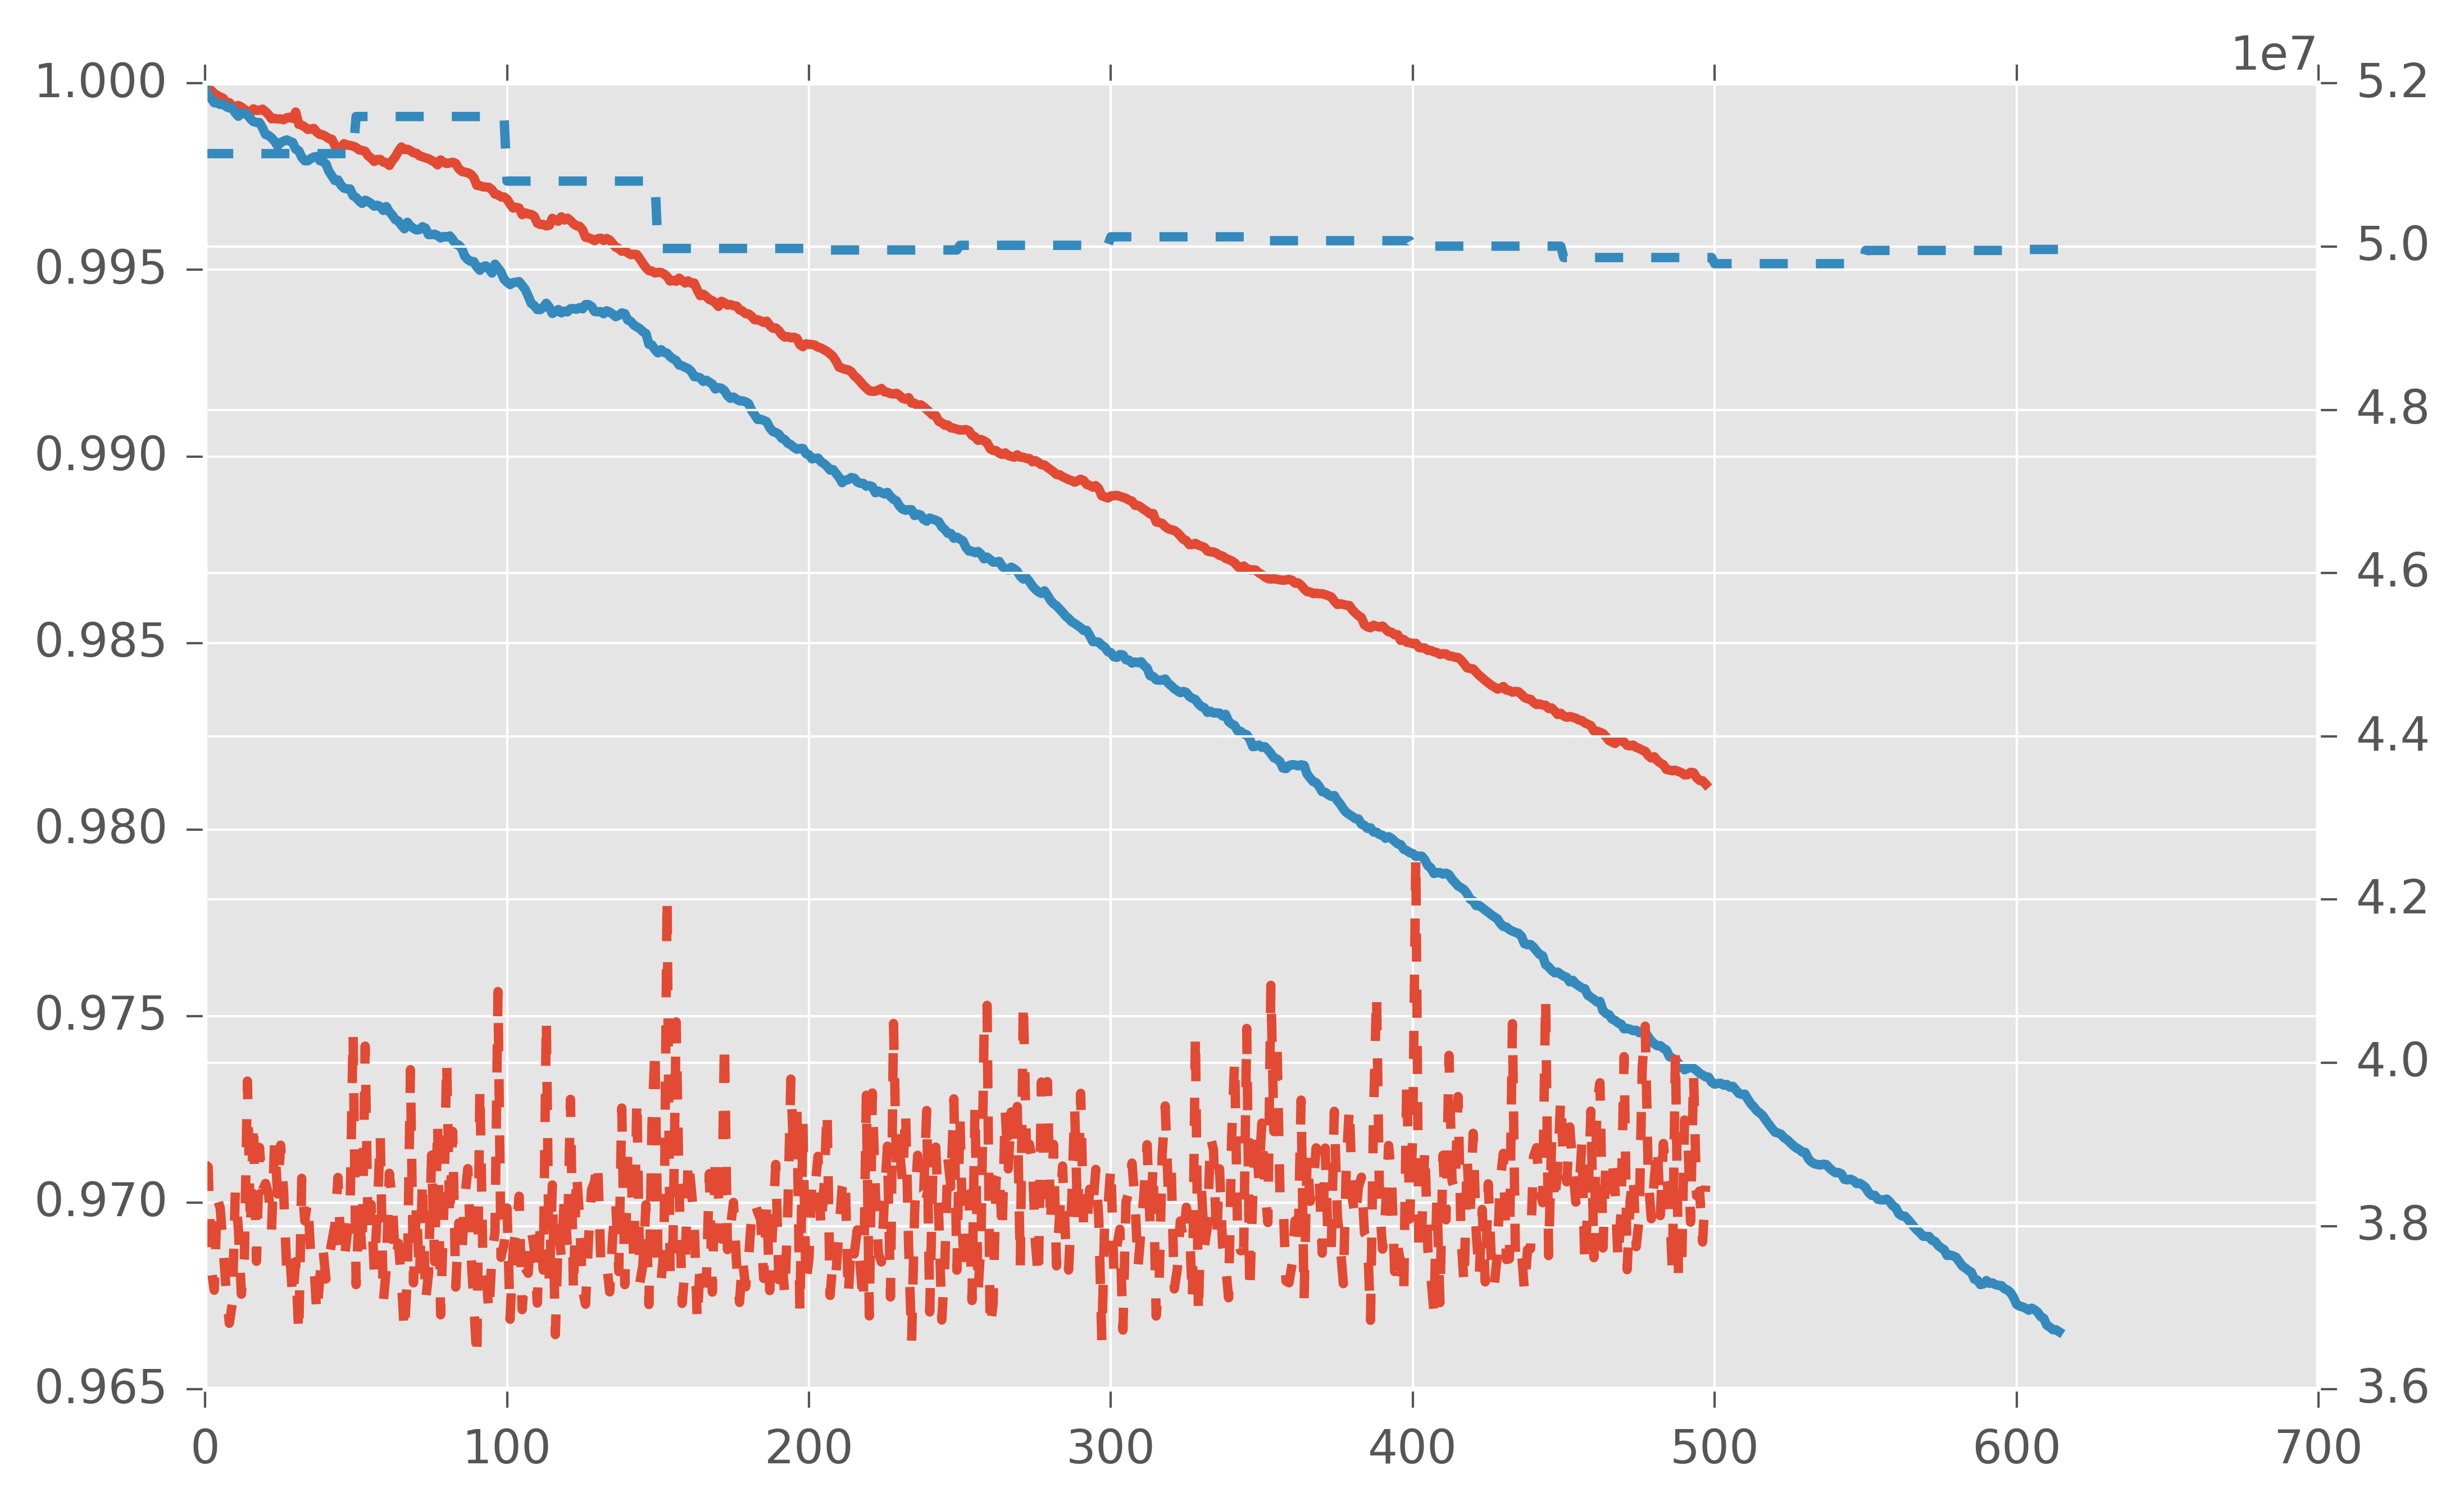

In [26]:
solution = tiht_mpa(A, y, 2 * RANK, batchsize=150, retinfo=['mu'],
                    stepsize={'method': 'adaptive_noproj', 'recalc': 50, 'join': 'average', 'scale': 1.3},
                    compargs={'method': 'svd'})
result_r = list(a for a in Progress(RuntimeSlice(solution, 30), rettime=True))

pl.plot([mp.normdist(X, X_sharp) for _, (X_sharp, _) in result])
pl.plot([mp.normdist(X, X_sharp) for _, (X_sharp, _) in result_r])

ax2 = pl.gca().twinx()
ax2.plot([info['mu'] for _, (_, info) in result], ls="--")
ax2.plot([info['mu'] for _, (_, info) in result_r], ls="--")

In [10]:
result_cs = dict()

for stepsize in [4e7, 5e7, 6e7, 7e7, 8e7, 9e7]:
    solution = tiht_mpa(A, y, 2 * RANK, stepsize=stepsize, batchsize=150)
    result_cs[stepsize] = list(a for a in Progress(RuntimeSlice(solution, 30), rettime=True))

100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30
100% |#####################################| Elapsed Time: 0:00:30 / 00:00:30


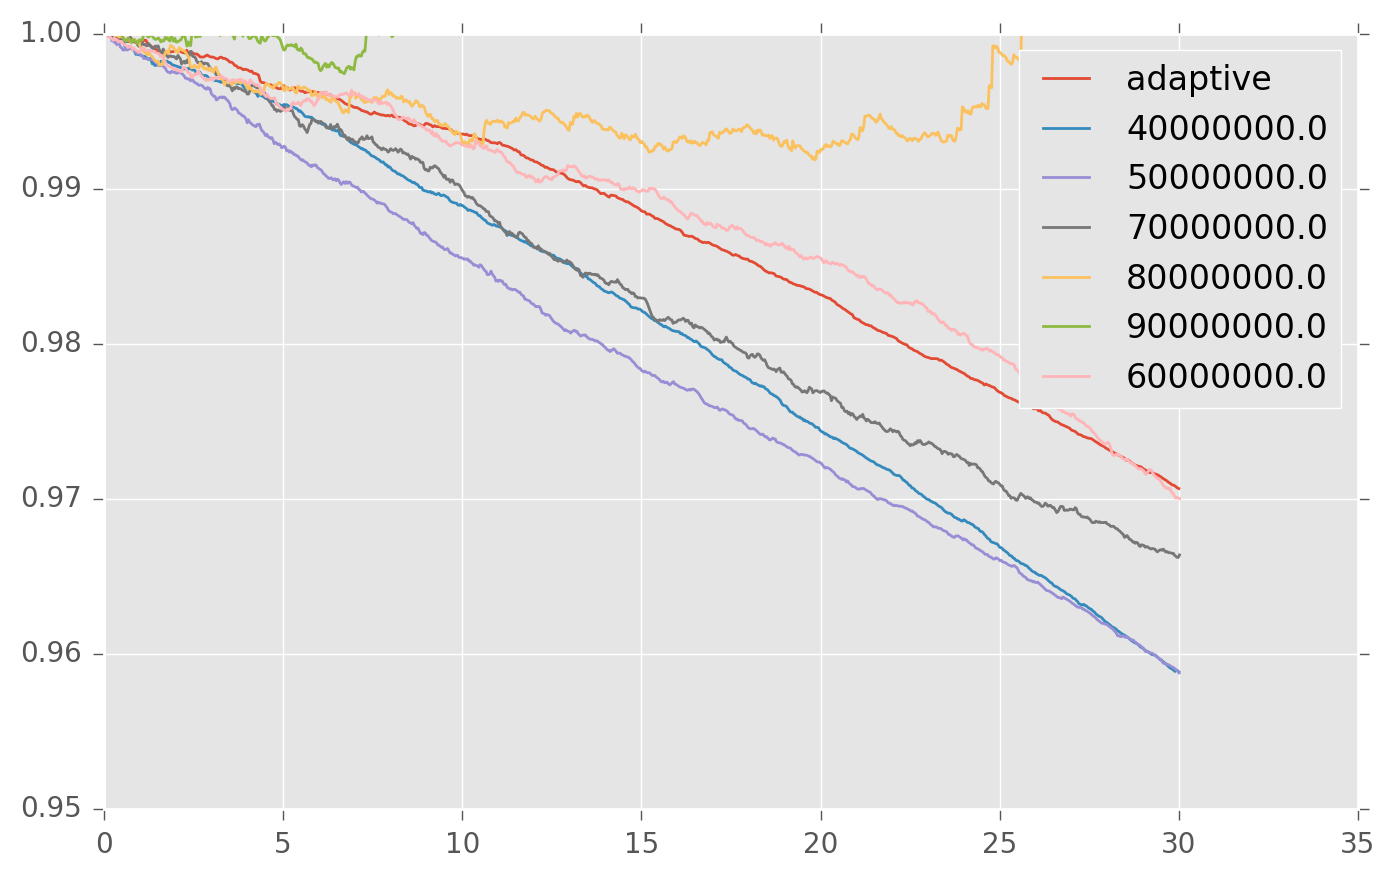

In [11]:
pl.plot([t for t, _ in result], [mp.normdist(X, Xsharp) for _, (Xsharp, _) in result], label='adaptive')
for key, val in result_cs.items():
    pl.plot([t for t, _ in val], [mp.normdist(X, Xsharp) for _, Xsharp in val], label=key)

pl.ylim((0.95, 1.0))
pl.legend()

### Running the simulation

In [15]:
res_mpa = [(mp.zero(SITES, LDIM, 1), None)]

In [16]:
ITSTEPS = 100
BATCHSIZE = 500


solution = tiht_mpa(A, y, 2 * RANK, stepsize='adaptive', retinfo=RETINFO,
                   batchsize=BATCHSIZE, X_init=res_mpa[-1][0])
with Timer():
    res_mpa += [p for p in islice(Progress(solution, max_value=ITSTEPS), ITSTEPS)]

pl.plot([mp.normdist(X, X_sharp) for X_sharp, _ in res_mpa], label='mpnum')

 28% ( 29 of 100) |######                  | Elapsed Time: 0:00:16 ETA: 0:00:36

Timer: 16.624500513076782s


 30% ( 30 of 100) |#######                 | Elapsed Time: 0:00:16 ETA: 0:00:35

KeyboardInterrupt: 